# Rede Hidrometeorológica Nacional

## Transformando vários arquivos de precipitação de uma vez

Trabalhando com os dados da Rede Hidrometeorológica Nacional, da Agência Nacional de Águas (ANA).

## Importando bibliotecas

In [1]:
import requests
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from shapely import geometry, ops
import fiona
import geopandas as gpd
from datetime import datetime, timedelta
from calendar import monthrange

In [ ]:
# # Atualizar o Google Download
# !pip install --upgrade --no-cache-dir gdown

## Fazer o download dos dados das estações

* CODIGOs: [1065002, 1068000, 1063000, 967002, 967000, 966000, 965001, 963001, 967001, 968001, 863000, 867001, 870000, 766001, 765000, 772000, 764003, 770000, 764001, 669000, 668000, 664000, 567001, 466001]


Acessar Hidroweb (https://www.snirh.gov.br/hidroweb) e ir em séries históricas (https://www.snirh.gov.br/hidroweb/serieshistoricas)

Selecionar Tipo estação **Pluviométrica** e código da estação **865000**, consultar e fazer o download do arquivo TXT.

### Passo importante!!

**Remover o cabeçalho do arquivo manualmente antes de importar no Google Drive!**

**Deixar somente o nome das colunas dos dados**


Copiar e colar o arquivo CSV no seu Google Drive, compartilhar com 'qualquer pessoa com o link' e copir o link:


* 24 pluviometros - https://drive.google.com/file/d/13iysxm8b4JxkegDp800Mkl4H9VxeErvH/view?usp=sharing


In [2]:
!gdown 13iysxm8b4JxkegDp800Mkl4H9VxeErvH

Downloading...
From: https://drive.google.com/uc?id=13iysxm8b4JxkegDp800Mkl4H9VxeErvH
To: /content/24_pluviometros.zip
100% 546k/546k [00:00<00:00, 108MB/s]


In [3]:
!unzip 24_pluviometros.zip
!rm -r __MACOSX

Archive:  24_pluviometros.zip
   creating: 24_pluviometros/
  inflating: 24_pluviometros/966000_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._966000_Chuvas.txt  
  inflating: 24_pluviometros/764001_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._764001_Chuvas.txt  
  inflating: 24_pluviometros/1068000_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._1068000_Chuvas.txt  
  inflating: 24_pluviometros/1065002_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._1065002_Chuvas.txt  
  inflating: 24_pluviometros/867001_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._867001_Chuvas.txt  
  inflating: 24_pluviometros/963001_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._963001_Chuvas.txt  
  inflating: 24_pluviometros/967001_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._967001_Chuvas.txt  
  inflating: 24_pluviometros/765000_Chuvas.txt  
  inflating: __MACOSX/24_pluviometros/._765000_Chuvas.txt  
  inflating: 24_pluviometros/772000_Chuvas.txt  
  inflating: __

In [4]:
serie_todos = pd.date_range(start='1980-01-01', end='2010-12-31',
                      freq="d")

df_todos = pd.DataFrame({'data':serie_todos})
df_todos['data'] = pd.to_datetime(df_todos['data'])
df_todos = df_todos.set_index('data')

lista = [1065002, 1068000, 1063000, 967000, 967002, 966000, 965001, 963001,
         967001, 968001, 863000, 867001, 870000, 766001, 765000, 772000,
         764003, 770000, 764001, 669000, 668000, 664000, 567001, 466001]

for i in range(len(lista)):
  #print(i, lista[i])
  print('24_pluviometros/'+str(lista[i])+'_Chuvas.txt')

  arquivo = '24_pluviometros/'+str(lista[i])+'_Chuvas.txt'
  df = pd.read_csv(arquivo,sep=';')
  df = df.replace(regex={',': '.'})

  # dados não consistidos
  df_Nconsist = df[df['NivelConsistencia']==1] # vamos usar os dados não consistidos

  df_Nconsist = df_Nconsist[['Data',
       'Chuva01', 'Chuva02', 'Chuva03', 'Chuva04', 'Chuva05', 'Chuva06',
       'Chuva07', 'Chuva08', 'Chuva09', 'Chuva10', 'Chuva11', 'Chuva12',
       'Chuva13', 'Chuva14', 'Chuva15', 'Chuva16', 'Chuva17', 'Chuva18',
       'Chuva19', 'Chuva20', 'Chuva21', 'Chuva22', 'Chuva23', 'Chuva24',
       'Chuva25', 'Chuva26', 'Chuva27', 'Chuva28', 'Chuva29', 'Chuva30',
       'Chuva31']]

  lista_Nconsist = []
  for j in range(len(df_Nconsist)):
    lista_Nconsist.append(datetime.strptime(df_Nconsist['Data'].values[j], '%d/%m/%Y'))

  df_Nconsist = df_Nconsist.reset_index()
  df_Nconsist['data-ok']  = lista_Nconsist

  df_total = pd.DataFrame()

  for j in range(0,len(df_Nconsist)):
    serie1 = pd.date_range(df_Nconsist['data-ok'][j],
                        periods=monthrange(df_Nconsist['data-ok'][j].year, df_Nconsist['data-ok'][j].month)[1],
                        freq="d")
    dados = []
    for k in range(2,len(serie1)+2):
      dados.append(df_Nconsist[df_Nconsist.columns[k]][j]) # k é a coluna dos dias do mês, j é a linha do dataframe

    df_mensal = pd.DataFrame({'data': serie1, 'prec(mm)': dados})
    df_total = pd.concat([df_total, df_mensal])

  df_total = df_total.set_index('data')
  df_total = df_total.astype({'prec(mm)': float})
  df_todos[str(lista[i])] = df_total['prec(mm)']

24_pluviometros/1065002_Chuvas.txt
24_pluviometros/1068000_Chuvas.txt
24_pluviometros/1063000_Chuvas.txt
24_pluviometros/967000_Chuvas.txt
24_pluviometros/967002_Chuvas.txt
24_pluviometros/966000_Chuvas.txt
24_pluviometros/965001_Chuvas.txt
24_pluviometros/963001_Chuvas.txt
24_pluviometros/967001_Chuvas.txt
24_pluviometros/968001_Chuvas.txt
24_pluviometros/863000_Chuvas.txt
24_pluviometros/867001_Chuvas.txt
24_pluviometros/870000_Chuvas.txt
24_pluviometros/766001_Chuvas.txt
24_pluviometros/765000_Chuvas.txt
24_pluviometros/772000_Chuvas.txt
24_pluviometros/764003_Chuvas.txt
24_pluviometros/770000_Chuvas.txt
24_pluviometros/764001_Chuvas.txt
24_pluviometros/669000_Chuvas.txt
24_pluviometros/668000_Chuvas.txt
24_pluviometros/664000_Chuvas.txt
24_pluviometros/567001_Chuvas.txt
24_pluviometros/466001_Chuvas.txt


In [5]:
df_todos

,1065002,1068000,1063000,967000,967002,966000,965001,963001,967001,968001,...,765000,772000,764003,770000,764001,669000,668000,664000,567001,466001
data,,,,,,,,,,,,,,,,,,,,,
1980-01-01,10.1,20.5,0.1,18.5,NaN,20.6,0.0,0.0,NaN,51.4,...,15.2,9.3,0.0,0.0,0.6,66.8,30.4,2.8,4.4,18.6
1980-01-02,0.0,0.0,0.0,0.0,NaN,0.0,2.0,0.0,NaN,0.0,...,16.4,0.0,21.8,0.0,4.7,29.0,0.0,1.0,22.6,8.4
1980-01-03,27.1,0.0,3.2,0.0,NaN,0.0,10.0,2.2,NaN,0.0,...,0.0,0.0,40.6,0.0,3.6,10.0,0.0,2.2,23.8,0.0
1980-01-04,16.2,0.0,4.0,13.6,NaN,1.0,0.0,6.4,NaN,5.6,...,0.0,20.2,0.0,10.3,6.5,6.0,0.0,5.0,0.0,21.2
1980-01-05,0.0,0.0,41.2,2.4,NaN,1.2,0.0,0.6,NaN,0.0,...,5.2,8.0,1.8,21.1,0.0,0.0,0.0,2.2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,0.0,0.0,9.8,0.4,NaN,0.0,18.7,0.0,0.6,0.1,...,1.6,NaN,9.3,0.0,NaN,NaN,11.3,0.0,56.3,0.0
2010-12-28,0.0,0.0,12.2,0.6,NaN,66.2,0.0,39.0,6.8,0.0,...,0.7,NaN,0.0,0.0,NaN,NaN,0.0,3.0,41.0,0.0
2010-12-29,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,0.0,1.6,33.0,0.0


<Axes: xlabel='data'>

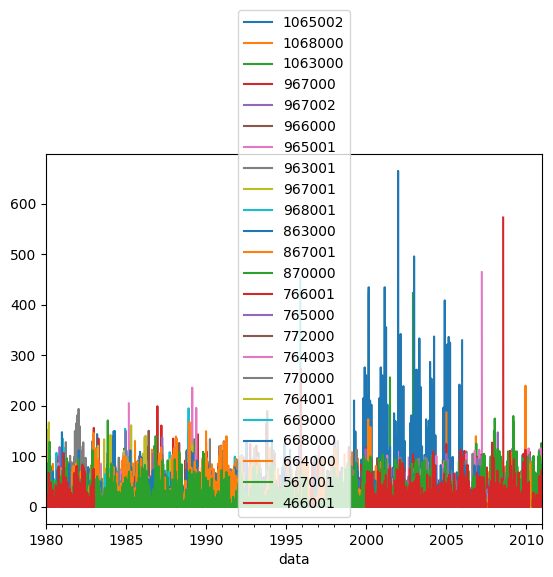

In [6]:
df_todos.plot()

In [7]:
df_todos.to_csv('prec_24_pluv.csv')

### Salvar o arquivo com todas as estações pluv. no Google Drive e abrir no notebook Aula09c